<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Mon Nov  6 14:14:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.62       Driver Version: 462.62       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8     5W /  N/A |    134MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
from argparse import ArgumentParser

parser = ArgumentParser()

parser.add_argument("--disable-cuda", default=False)
parser.add_argument("-f", required=False)

arg = parser.parse_args()
arg.device = None
if not arg.disable_cuda and torch.cuda.is_available():
    arg.device = torch.device("cuda:0")
else:
    arg.device = torch.device("cpu")
    
arg.device

2.0.1+cu117


device(type='cuda', index=0)

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
def download_data():
    pass

# 1. Get data
import pathlib
from pathlib import Path
data_dir = Path("../../module/data") / "pizza_steak_sushi"


if data_dir.is_dir():
    print("Data has been downloaded. Skip...")
else:
    print("Downloading...")
    download_data()

Data has been downloaded. Skip...


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
walk_through_dir(data_dir)

There are 2 directories and 1 images in '..\..\module\data\pizza_steak_sushi'.
There are 3 directories and 0 images in '..\..\module\data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in '..\..\module\data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in '..\..\module\data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in '..\..\module\data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in '..\..\module\data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in '..\..\module\data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in '..\..\module\data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in '..\..\module\data\pizza_steak_sushi\train\sushi'.


In [5]:
# Setup train and testing paths
train_path = data_dir / "train"
test_path = data_dir / "test"

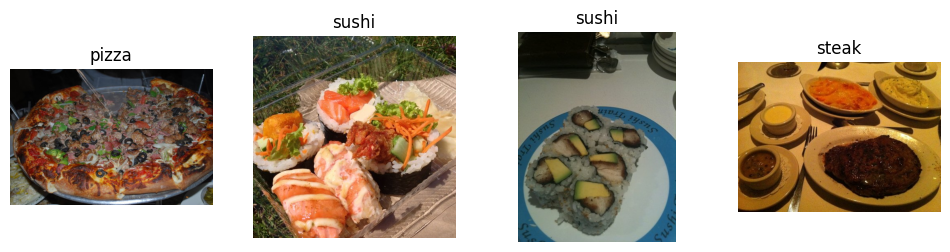

In [6]:
# Visualize an image
from PIL import Image
from glob import glob
import random
import matplotlib.pyplot as plt

image_list_path = sorted(list(train_path.glob("*/*.jpg")))



def visualize_image(image_paths: str,
                    n: int = 4, 
                    seed: int = 82) -> None:
    image_list_path = sorted(list(image_paths.glob("*/*.jpg")))
    random.seed(seed)
    plt.figure(figsize=(12, 6))
    for idx, image_path in enumerate(random.sample(image_list_path, k=n)):
        plt.subplot((n // 4) + 1, 4, idx + 1)
        image = Image.open(image_path)
        class_name = image_path.parent.stem
        
        plt.imshow(image)
        plt.title(class_name)
        plt.axis(False)
        
    
    

visualize_image(test_path)

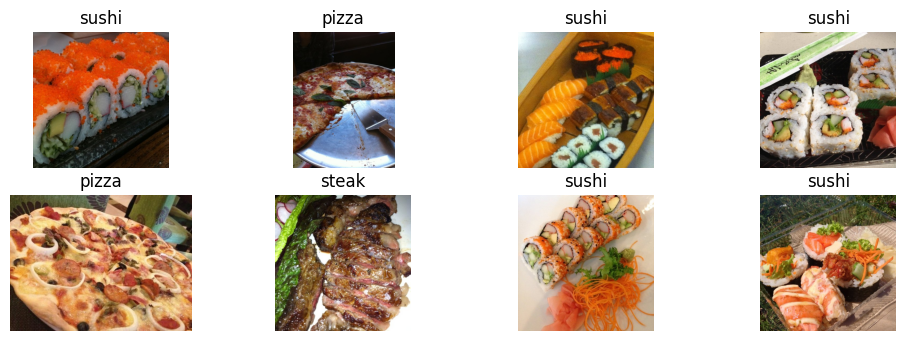

In [7]:
# Do the image visualization with matplotlib
visualize_image(test_path, n = 8, seed = 10)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [8]:
# 3.1 Transforming data with torchvision.transforms
from torchvision.transforms import Compose, TrivialAugmentWide, \
                                   ToTensor, Resize, \
                                   Normalize \

train_transform = Compose([
    Resize((64, 64)),
    TrivialAugmentWide(num_magnitude_bins=2),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transform = Compose([
    Resize((64, 64)),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


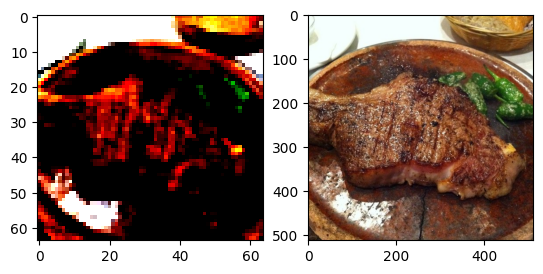

In [9]:
# Write transform for turning images into tensors
image = Image.open(image_list_path[82])

plt.subplot(1, 2, 1)
plt.imshow(train_transform(image).permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(image)

In [10]:
train_transform(image).dtype

torch.float32

In [11]:
type(train_path)

pathlib.WindowsPath

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


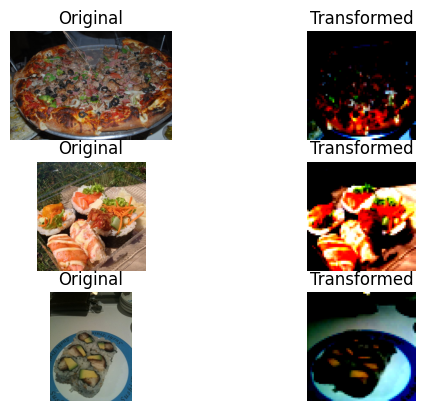

In [12]:
# Write a function to plot transformed images
def visualize_transform_image(image_paths: pathlib.WindowsPath,
                              transform: Compose,
                              n: int = 3, 
                              seed: int = 82) -> None:
    random.seed(seed)
    image_path_list = sorted(list(image_paths.glob("*/*.jpg")))
    fig, ax = plt.subplots(n, 2)
    ax = ax.flatten()
    
    for idx, image_path in enumerate(random.sample(image_path_list, k=n)):
        image = Image.open(image_path)
        ax[2 * idx].imshow(image)
        ax[2 * idx].set_title("Original")
        ax[2 * idx].axis("off")
        
        ax[2 * idx + 1].imshow(transform(image).permute(1, 2, 0))
        ax[2 * idx + 1].set_title("Transformed")
        ax[2 * idx + 1].axis("off")
        
    plt.show()
        
        
visualize_transform_image(test_path, test_transform)

### Load image data using `ImageFolder`

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=train_path, transform=train_transform, target_transform=None)

test_dataset = ImageFolder(root=test_path, transform=test_transform, target_transform=None)

In [14]:
# Get class names as a list
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Can also get class names as a dict
class_dict = train_dataset.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of each dataset
len(train_dataset), len(test_dataset)

(225, 75)

In [17]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
batch_size = 64
num_workers = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               num_workers=num_workers,
                               shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                               batch_size=batch_size,
                               num_workers=num_workers,
                               shuffle=True)

In [18]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(4, 2)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [19]:
class TinyModel(nn.Module):
    def __init__(self, in_channels: int,  out_classes: int, hidden_units: int = 10) -> None:
        super(TinyModel, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2)
        self.conv2d = nn.Conv2d(in_channels,hidden_units, 3, 1, 1)
        self.block_1 = self._block(in_channels = hidden_units, out_channels = hidden_units)
        self.block_2 = self._block(in_channels=hidden_units, out_channels=hidden_units)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 16 * 16, 256),
            nn.Linear(256, 64),
            nn.Linear(64, 3),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv2d(x)
        x = self.maxpool(self.block_1(x) + x)
        x = self.maxpool(self.block_2(x) + x)
        return self.classifier(x)
        
    
    def _block(self, in_channels: int, 
               out_channels: int, 
               kernel_size: int = 3, 
               stride: int = 1, 
               padding: int = 1) -> nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
        )
    
model_0 = TinyModel(in_channels=3, out_classes=3).to(arg.device)
model_0

TinyModel(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block_1): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [20]:
image, label = next(iter(test_dataloader))
label.shape, model_0(image.to(arg.device)).shape

(torch.Size([64]), torch.Size([64, 3]))

## 4. Create training and testing functions for `model_0`.

In [21]:
def accuracy_fn(y_preds, y_true):
    return ((y_preds == y_true).sum() / len(y_true)).item()


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = arg.device):
  
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader and data batches
    for idx, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_logits = model(X)
        
        # 2. Optimizer zero grad 
        optimizer.zero_grad()
        
        # 3. Calculate and accumulate loss
        loss = loss_fn(y_logits, y)

        # 4. Loss backward 
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumualte accuracy metric across all batches
        with torch.inference_mode():
            acc = accuracy_fn(y_logits.argmax(dim = 1), y)
            train_acc += acc
            train_loss += loss
        
        if idx % 40 == 0 and idx != 0:
            print(f"Trained on {idx * len(X)}/{len(dataloader.dataset)}")

    # Adjust metrics to get average loss and average accuracy per batch
    with torch.inference_mode():
        train_acc /= len(dataloader)
        train_loss /= len(dataloader)
    
    print("Train loss {:.4f} | Train accuracy {:.4f}".format(
        train_loss, train_acc
    ))
    
    return train_loss, train_acc

In [22]:
@torch.inference_mode()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device : torch.device = arg.device):
  
    # Put model in eval mode
    model.eval()

    # Setup the test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager

    # Loop through DataLoader batches
    for X, y in dataloader:
      # Send data to target  device
        X, y = X.to(device), y.to(device)

      # 1. Forward pass
        y_logits = model(X)

      # 2. Calculuate and accumulate loss
        loss = loss_fn(y_logits, y)

      # Calculate and accumulate accuracy
        acc = accuracy_fn(y_logits.argmax(dim = 1), y)
        test_loss += loss
        test_acc += acc

    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    
    print("Test loss {:.4f} | Test accuracy {:.4f}".format(
        test_loss, test_acc
    ))
    
    return test_loss, test_acc

In [23]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [24]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

epochs = 5
train(model=model_0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs = epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss 1.7828 | Train accuracy 0.3561
Test loss 1.5388 | Test accuracy 0.3239
Epoch: 1 | train_loss: 1.7828 | train_acc: 0.3561 | test_loss: 1.5388 | test_acc: 0.3239
Train loss 1.2250 | Train accuracy 0.4615
Test loss 1.1040 | Test accuracy 0.2642
Epoch: 2 | train_loss: 1.2250 | train_acc: 0.4615 | test_loss: 1.1040 | test_acc: 0.2642
Train loss 1.1324 | Train accuracy 0.4041
Test loss 0.9642 | Test accuracy 0.4538
Epoch: 3 | train_loss: 1.1324 | train_acc: 0.4041 | test_loss: 0.9642 | test_acc: 0.4538
Train loss 0.9467 | Train accuracy 0.5272
Test loss 1.0049 | Test accuracy 0.5227
Epoch: 4 | train_loss: 0.9467 | train_acc: 0.5272 | test_loss: 1.0049 | test_acc: 0.5227
Train loss 0.9636 | Train accuracy 0.5121
Test loss 1.1315 | Test accuracy 0.4695
Epoch: 5 | train_loss: 0.9636 | train_acc: 0.5121 | test_loss: 1.1315 | test_acc: 0.4695


{'train_loss': [tensor(1.7828, device='cuda:0'),
  tensor(1.2250, device='cuda:0'),
  tensor(1.1324, device='cuda:0'),
  tensor(0.9467, device='cuda:0'),
  tensor(0.9636, device='cuda:0')],
 'train_acc': [0.35606060922145844,
  0.46152935922145844,
  0.4041193202137947,
  0.5272253751754761,
  0.5120738670229912],
 'test_loss': [tensor(1.5388, device='cuda:0'),
  tensor(1.1040, device='cuda:0'),
  tensor(0.9642, device='cuda:0'),
  tensor(1.0049, device='cuda:0'),
  tensor(1.1315, device='cuda:0')],
 'test_acc': [0.3238636404275894,
  0.26420454680919647,
  0.45383523404598236,
  0.5227272808551788,
  0.46946023404598236]}

In [25]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

epochs = 20
result_v1 = train(model=model_0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs = epochs)

result_v1

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss 1.0259 | Train accuracy 0.5182
Test loss 1.3642 | Test accuracy 0.3175
Epoch: 1 | train_loss: 1.0259 | train_acc: 0.5182 | test_loss: 1.3642 | test_acc: 0.3175
Train loss 0.9432 | Train accuracy 0.5360
Test loss 1.0511 | Test accuracy 0.4382
Epoch: 2 | train_loss: 0.9432 | train_acc: 0.5360 | test_loss: 1.0511 | test_acc: 0.4382
Train loss 0.9227 | Train accuracy 0.6046
Test loss 1.0972 | Test accuracy 0.3942
Epoch: 3 | train_loss: 0.9227 | train_acc: 0.6046 | test_loss: 1.0972 | test_acc: 0.3942
Train loss 0.8596 | Train accuracy 0.5888
Test loss 0.9628 | Test accuracy 0.5604
Epoch: 4 | train_loss: 0.8596 | train_acc: 0.5888 | test_loss: 0.9628 | test_acc: 0.5604
Train loss 0.7977 | Train accuracy 0.6894
Test loss 0.9881 | Test accuracy 0.4162
Epoch: 5 | train_loss: 0.7977 | train_acc: 0.6894 | test_loss: 0.9881 | test_acc: 0.4162
Train loss 0.7912 | Train accuracy 0.7018
Test loss 1.0195 | Test accuracy 0.4162
Epoch: 6 | train_loss: 0.7912 | train_acc: 0.7018 | test_loss: 

{'train_loss': [tensor(1.0259, device='cuda:0'),
  tensor(0.9432, device='cuda:0'),
  tensor(0.9227, device='cuda:0'),
  tensor(0.8596, device='cuda:0'),
  tensor(0.7977, device='cuda:0'),
  tensor(0.7912, device='cuda:0'),
  tensor(0.7282, device='cuda:0'),
  tensor(0.7159, device='cuda:0'),
  tensor(0.6671, device='cuda:0'),
  tensor(0.6470, device='cuda:0'),
  tensor(0.7253, device='cuda:0'),
  tensor(0.6199, device='cuda:0'),
  tensor(0.5268, device='cuda:0'),
  tensor(0.4898, device='cuda:0'),
  tensor(0.5686, device='cuda:0'),
  tensor(0.4702, device='cuda:0'),
  tensor(0.4322, device='cuda:0'),
  tensor(0.4479, device='cuda:0'),
  tensor(0.4346, device='cuda:0'),
  tensor(0.4185, device='cuda:0')],
 'train_acc': [0.5182291716337204,
  0.5359848514199257,
  0.6046401560306549,
  0.5887784063816071,
  0.689393937587738,
  0.7018229216337204,
  0.7165009528398514,
  0.6944839060306549,
  0.7277462184429169,
  0.7399384528398514,
  0.7211174368858337,
  0.7562736868858337,
  0.78610

In [26]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

epochs = 50
result_v2 = train(model=model_0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs = epochs)

result_v2

  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 0.6635 | Train accuracy 0.7436
Test loss 2.4665 | Test accuracy 0.2798
Epoch: 1 | train_loss: 0.6635 | train_acc: 0.7436 | test_loss: 2.4665 | test_acc: 0.2798
Train loss 0.5928 | Train accuracy 0.7629
Test loss 1.1331 | Test accuracy 0.4318
Epoch: 2 | train_loss: 0.5928 | train_acc: 0.7629 | test_loss: 1.1331 | test_acc: 0.4318
Train loss 0.5892 | Train accuracy 0.7668
Test loss 1.2046 | Test accuracy 0.3643
Epoch: 3 | train_loss: 0.5892 | train_acc: 0.7668 | test_loss: 1.2046 | test_acc: 0.3643
Train loss 0.3768 | Train accuracy 0.8835
Test loss 1.2790 | Test accuracy 0.4226
Epoch: 4 | train_loss: 0.3768 | train_acc: 0.8835 | test_loss: 1.2790 | test_acc: 0.4226
Train loss 0.3935 | Train accuracy 0.8447
Test loss 0.8497 | Test accuracy 0.6058
Epoch: 5 | train_loss: 0.3935 | train_acc: 0.8447 | test_loss: 0.8497 | test_acc: 0.6058
Train loss 0.3811 | Train accuracy 0.8879
Test loss 1.0904 | Test accuracy 0.4851
Epoch: 6 | train_loss: 0.3811 | train_acc: 0.8879 | test_loss: 

Train loss 0.3342 | Train accuracy 0.8881
Test loss 1.6348 | Test accuracy 0.3942
Epoch: 49 | train_loss: 0.3342 | train_acc: 0.8881 | test_loss: 1.6348 | test_acc: 0.3942
Train loss 0.3511 | Train accuracy 0.8567
Test loss 1.6022 | Test accuracy 0.4382
Epoch: 50 | train_loss: 0.3511 | train_acc: 0.8567 | test_loss: 1.6022 | test_acc: 0.4382


{'train_loss': [tensor(0.6635, device='cuda:0'),
  tensor(0.5928, device='cuda:0'),
  tensor(0.5892, device='cuda:0'),
  tensor(0.3768, device='cuda:0'),
  tensor(0.3935, device='cuda:0'),
  tensor(0.3811, device='cuda:0'),
  tensor(0.2997, device='cuda:0'),
  tensor(0.3686, device='cuda:0'),
  tensor(0.3530, device='cuda:0'),
  tensor(0.3914, device='cuda:0'),
  tensor(0.3704, device='cuda:0'),
  tensor(0.3256, device='cuda:0'),
  tensor(0.2843, device='cuda:0'),
  tensor(0.2933, device='cuda:0'),
  tensor(0.3415, device='cuda:0'),
  tensor(0.2731, device='cuda:0'),
  tensor(0.3688, device='cuda:0'),
  tensor(0.3337, device='cuda:0'),
  tensor(0.3883, device='cuda:0'),
  tensor(0.3498, device='cuda:0'),
  tensor(0.3079, device='cuda:0'),
  tensor(0.5197, device='cuda:0'),
  tensor(0.3944, device='cuda:0'),
  tensor(0.2645, device='cuda:0'),
  tensor(0.4031, device='cuda:0'),
  tensor(0.3718, device='cuda:0'),
  tensor(0.3579, device='cuda:0'),
  tensor(0.3681, device='cuda:0'),
  tens

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [27]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyModel(in_channels = 3, out_channels = 3, hidden_units = 20).to(arg.device)

loss_fn = nn.CrossEntropyLoss().to(arg.device)
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=1e-3)
epochs = 20
result_v3 = train(model=model_1,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs = epochs)

result_v3

TypeError: __init__() got an unexpected keyword argument 'out_channels'

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

In [ ]:
# See how many images we have
walk_through_dir(image_path)

Excellent, we now have double the training and testing images... 

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

batch_size = 8

# Create datasets
train_data = ImageFolder(root=train_data_20_percent_path,
                         transform=simple_transform,
                         target_transform=None)

test_data = ImageFolder(root=test_data_20_percent_path,
                         transform=simple_transform,
                         target_transform=None)

import os
num_workers = os.cpu_counts()

# Create dataloaders
train_dataloader = DataLoader(dataset=train_data,
                              shuffle=True,
                              batch_size=batch_size,
                              num_workers=num_workers)

test_dataloader = DataLoader(dataset=test_data,
                              shuffle=False,
                              batch_size=batch_size,
                              num_workers=num_workers)

In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?